## 1. 데이터 준비

데이터 수집 및 시각화

In [1]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.3.0


In [2]:
DATASET_PATH=os.path.join(os.getenv('HOME'),'project/aiffel/e/e27')

if not os.path.isdir(DATASET_PATH):
    os.makedirs(DATASET_PATH)

import urllib.request
u = urllib.request.urlopen(url='https://aiffelstaticprd.blob.core.windows.net/media/documents/sd_train.zip')
data = u.read()
u.close()

with open('sd_train.zip', "wb") as f :
    f.write(data)
    print('Data has been downloaded')

#shutil.move(os.path.join('sd_train.zip'), os.path.join(DATASET_PATH))
file_path = os.path.join(DATASET_PATH, 'sd_train.zip')

import zipfile
zip_ref = zipfile.ZipFile(file_path, 'r')
zip_ref.extractall(DATASET_PATH)
zip_ref.close()
print('Data has been extracted.')

Data has been downloaded
Data has been extracted.


train / test data 로 분리

In [3]:
img_dir = os.path.join(DATASET_PATH, 'train')
label_dir = os.path.join(DATASET_PATH, 'train_labels')

x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)] 
y_train_filenames.sort()

x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [4]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print('Number of training examples: {}'.format(num_train_examples))
print('Number of test examples: {}'.format(num_test_examples))

Number of training examples: 480
Number of test examples: 120


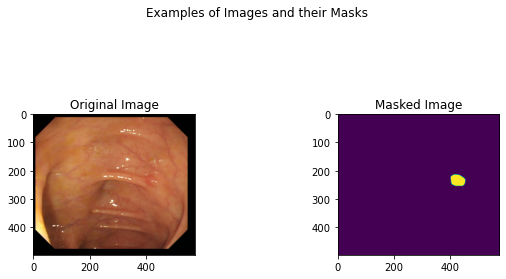

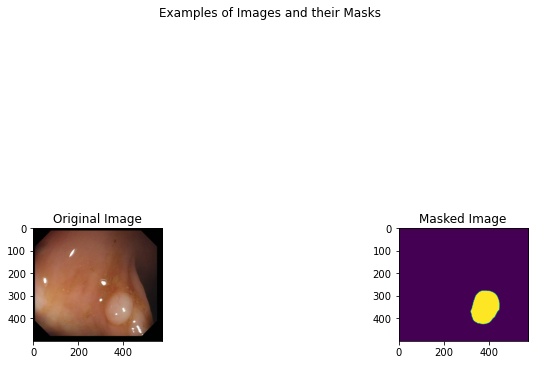

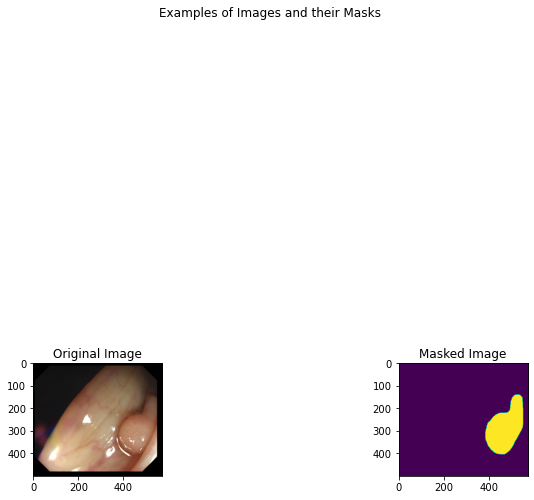

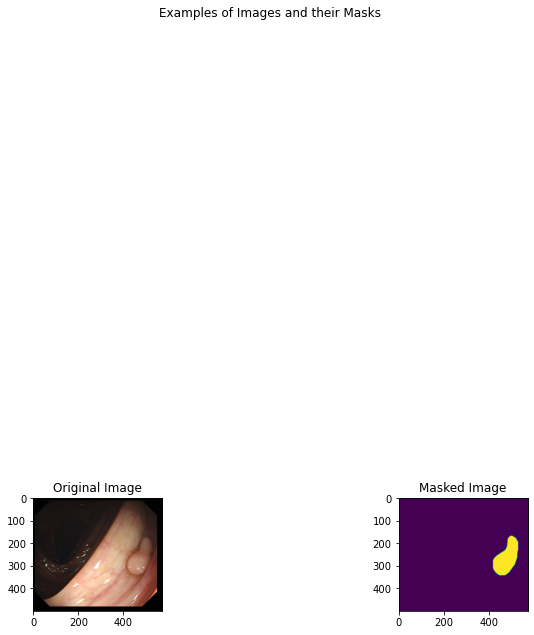

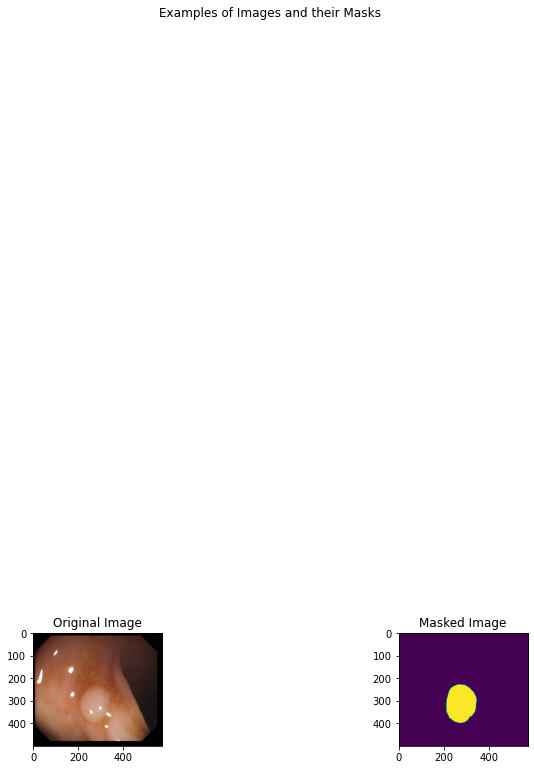

In [5]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num*2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]
    
    plt.subplot(display_num, 2, i+1)
    plt.imshow(Image.open(x_pathname))
    plt.title('Original Image')
    
    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)
    
    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title('Masked Image')

    plt.suptitle('Examples of Images and their Masks')
    plt.show()

### 데이터 전처리

하이퍼 파라미터

In [6]:
# Set hyperparameters

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 50

tf.data를 활용한 입력 파이프라인 설계

In [7]:
def _process_pathnames(fname, label_path):
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)
    
    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=1)
    
    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)
    
    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    
    return img, label_img

In [8]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random.uniform([], 
                                                  -width_shift_range * img_shape[1], 
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
            height_shift_range = tf.random.uniform([],
                                                  -height_shift_range * img_shape[0],
                                                  height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                        [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img, [width_shift_range, height_shift_range])
        
    return output_img, label_img

In [9]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                   lambda: (tf.image.flip_left_right(tr_img),
                                          tf.image.flip_left_right(label_img)),
                                   lambda: (tr_img, label_img))
    return tr_img, label_img

In [10]:
def _augment(img, label_img, resize=None, scale=1, hue_delta=0., horizontal_flip=True, 
            width_shift_range=0.05, height_shift_range=0.05):
    if resize is not None:
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
    
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
    
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    
    return img, label_img

Set up train / test datasets

In [11]:
def get_baseline_dataset(filenames, labels, preproc_fn=functools.partial(_augment),
                        threads=4, batch_size=batch_size, is_train=True):
    num_x = len(filenames)
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
    
    if is_train:
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)
    
    dataset = dataset.batch(batch_size)
    return dataset

In [12]:
train_dataset = get_baseline_dataset(x_train_filenames, y_train_filenames)
train_dataset = train_dataset.repeat()

test_dataset = get_baseline_dataset(x_test_filenames, y_test_filenames, is_train=False)

train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

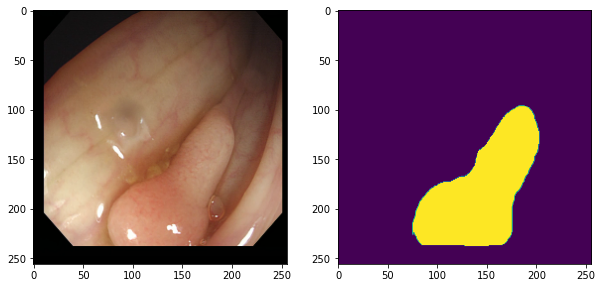

In [13]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    img = images[0]
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    
    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

## 2. 모델 설계

### U-Net

In [14]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()
    
    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)
        
        return x

In [15]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters*2, 3)
    
    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)
        
        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)
        
    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)
    
        return decoder
    
class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()
        
    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)
        
        return encoder_pool, encoder

class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)
    
    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)
        
        return decoder

In [16]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)
        
        self.center = ConvBlock(1024)
        
        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)
        
        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')
        
    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)
    
        center = self.center(encoder4_pool)
        
        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)
        
        return outputs

In [17]:
unet_model = UNet()

metrics / loss functions

In [67]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10

    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [68]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [69]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [21]:
optimizer = tf.keras.optimizers.Adam()

select / compile model

In [22]:
model = unet_model
checkpoint_dir = os.path.join(DATASET_PATH, 'train_ckpt/unet_model')

In [23]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [24]:
model.summary()

Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block (EncoderBlock) multiple                  76416     
_________________________________________________________________
encoder_block_1 (EncoderBloc multiple                  444288    
_________________________________________________________________
encoder_block_2 (EncoderBloc multiple                  1773312   
_________________________________________________________________
encoder_block_3 (EncoderBloc multiple                  7085568   
_________________________________________________________________
conv_block_4 (ConvBlock)     multiple                  28326912  
_________________________________________________________________
decoder_block (DecoderBlock) multiple                  18882048  
_________________________________________________________________
decoder_block_1 (DecoderBloc multiple                  354278

callback

In [25]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0
                                                )

In [26]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

## 3. 모델 학습 및 평가

In [27]:
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)
        
        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0, :, :, :])
        plt.title('Input Image')
        
        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title('Actual Mask')
        
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title('Predicted Mask')
        plt.show()

In [28]:
history = model.fit(train_dataset,
                   epochs=max_epochs,
                   steps_per_epoch=num_train_examples // batch_size,
                   validation_data=test_dataset,
                   validation_steps=num_test_examples // batch_size,
                   callbacks=[cp_callback, lr_callback])


Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
Epoch 1/50
60/60 [==============================] - 44s 738ms/step - loss: 1.0317 - dice_loss: 0.7161 - val_loss: 9.2269 - val_dice_loss: 0.9997

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990134, shape=(), dtype=float32).
Epoch 2/50
60/60 [==============================] - 43s 713ms/step - loss: 0.9107 - dice_loss: 0.6992 - val_loss: 4.0824 - val_dice_loss: 1.0000

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009960574, shape=(), dtype=float32).
Epoch 3/50
60/60 [==============================] - 41s 688ms/step - loss: 0.8937 - dice_loss: 0.6878 - val_loss: 1.3879 - val_dice_loss: 0.9961

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009911436, shape=(), dtype=float32).
Epoch 4/50
60/60 [==============================] - 40s 659ms/step - loss: 0.8663 - dice_loss: 0.6697 - val_loss: 1.7496 - v

60/60 [==============================] - 37s 620ms/step - loss: 0.1014 - dice_loss: 0.0738 - val_loss: 0.1713 - val_dice_loss: 0.1284

Epoch 00031: LearningRateScheduler reducing learning rate to tf.Tensor(0.00034549143, shape=(), dtype=float32).
Epoch 31/50
60/60 [==============================] - 37s 623ms/step - loss: 0.0964 - dice_loss: 0.0703 - val_loss: 0.1413 - val_dice_loss: 0.1058

Epoch 00032: LearningRateScheduler reducing learning rate to tf.Tensor(0.0003159377, shape=(), dtype=float32).
Epoch 32/50
60/60 [==============================] - 41s 681ms/step - loss: 0.1036 - dice_loss: 0.0761 - val_loss: 0.1162 - val_dice_loss: 0.0860

Epoch 00033: LearningRateScheduler reducing learning rate to tf.Tensor(0.00028711034, shape=(), dtype=float32).
Epoch 33/50
60/60 [==============================] - 37s 623ms/step - loss: 0.0917 - dice_loss: 0.0670 - val_loss: 0.1872 - val_dice_loss: 0.1412

Epoch 00034: LearningRateScheduler reducing learning rate to tf.Tensor(0.0002591231, shap

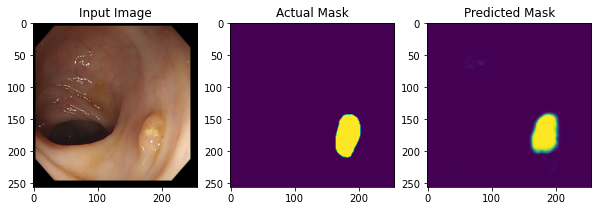

In [29]:
print_images()

Plot the loss

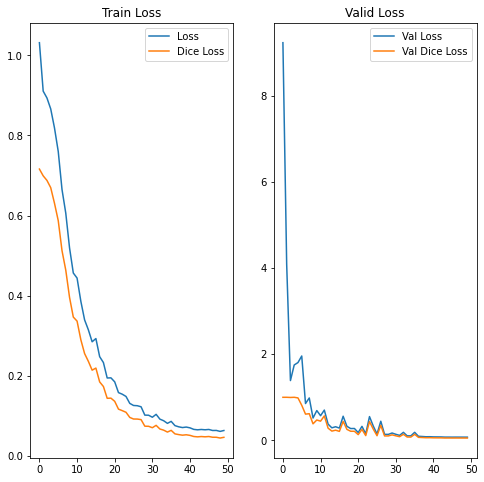

In [62]:
_dice_loss = history.history['dice_loss']
_loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, _loss, label='Loss')
plt.plot(epochs_range, _dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

Restore the latest checkpoint

In [31]:
model.load_weights(checkpoint_dir)

Evaluate the test dataset

In [32]:
def mean_iou(y_true, y_pred, num_classes=2):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()
    
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)
    
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    
    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [65]:
_mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    _mean.append(m)

_mean = np.array(_mean)
_mean = np.mean(_mean)
print('mean_iou: {}'.format(_mean))

mean_iou: 0.9290119885196848


In [34]:
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)
        
        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i, :, :, :])
            plt.title('Input image')
            
            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title('Actual Mask')
            
            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title('Predicted Mask')
            plt.show()

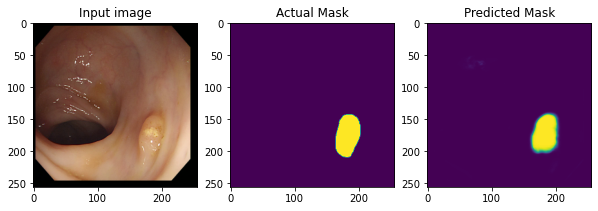

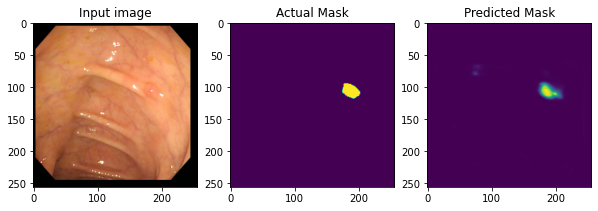

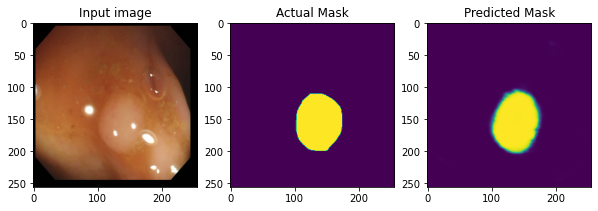

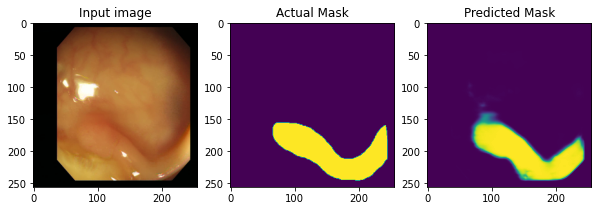

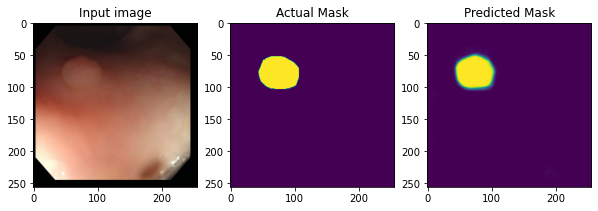

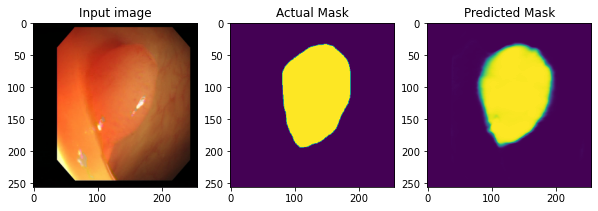

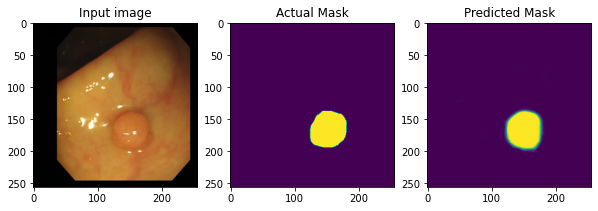

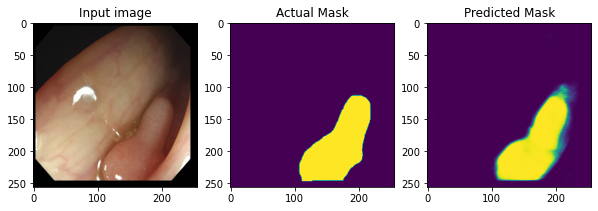

In [35]:
print_images()

## 4. UNet 모델 개선

pretrained model_VGG16 as Encoder

In [71]:
vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
layer_outputs = [layer.output for layer in vgg16.layers]
layer_outputs

[<tf.Tensor 'input_4:0' shape=(None, 256, 256, 3) dtype=float32>,
 <tf.Tensor 'block1_conv1/Relu_3:0' shape=(None, 256, 256, 64) dtype=float32>,
 <tf.Tensor 'block1_conv2/Relu_3:0' shape=(None, 256, 256, 64) dtype=float32>,
 <tf.Tensor 'block1_pool/MaxPool_3:0' shape=(None, 128, 128, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1/Relu_3:0' shape=(None, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'block2_conv2/Relu_3:0' shape=(None, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'block2_pool/MaxPool_3:0' shape=(None, 64, 64, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1/Relu_3:0' shape=(None, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'block3_conv2/Relu_3:0' shape=(None, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'block3_conv3/Relu_3:0' shape=(None, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'block3_pool/MaxPool_3:0' shape=(None, 32, 32, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1/Relu_3:0' shape=(None, 32, 32, 512) dtype=float32>,
 <tf.Tensor 'block4_conv2/Relu_3:0' shape=(None, 32, 32, 512) d

In [72]:
class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2], 
                                               layer_outputs[5], 
                                               layer_outputs[9], 
                                               layer_outputs[13], 
                                               layer_outputs[17]])


        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):

        encoder1, encoder2, encoder3, encoder4, encoder4_pool = self.vgg16_act(inputs) 
        
        center = self.center(encoder4_pool)
        
        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)

        return outputs

In [73]:
vgg_unet = Vgg16UNet()
checkpoint_dir = os.path.join(DATASET_PATH, 'train_ckpt/vgg_unet_model')

In [74]:
vgg_unet.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = vgg_unet(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [75]:
vgg_unet.summary()

Model: "vgg16u_net_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
functional_5 (Functional)    [(None, 256, 256, 64), (N 14714688  
_________________________________________________________________
conv_block_7 (ConvBlock)     multiple                  23608320  
_________________________________________________________________
decoder_block_12 (DecoderBlo multiple                  16522752  
_________________________________________________________________
decoder_block_13 (DecoderBlo multiple                  2952960   
_________________________________________________________________
decoder_block_14 (DecoderBlo multiple                  739200    
_________________________________________________________________
decoder_block_15 (DecoderBlo multiple                 

In [76]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [77]:
history_vggunet = vgg_unet.fit(train_dataset,
                               epochs=max_epochs,
                               steps_per_epoch=num_train_examples // batch_size,
                               validation_data=test_dataset,
                               validation_steps=num_test_examples // batch_size,
                               callbacks=[cp_callback, lr_callback]
                              )


Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
Epoch 1/50
60/60 [==============================] - 33s 555ms/step - loss: 0.9699 - dice_loss: 0.7254 - val_loss: 8.7893 - val_dice_loss: 1.0000

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990134, shape=(), dtype=float32).
Epoch 2/50
60/60 [==============================] - 33s 545ms/step - loss: 0.9041 - dice_loss: 0.7048 - val_loss: 1.6235 - val_dice_loss: 0.9999

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009960574, shape=(), dtype=float32).
Epoch 3/50
60/60 [==============================] - 30s 508ms/step - loss: 0.8844 - dice_loss: 0.6878 - val_loss: 0.9703 - val_dice_loss: 0.7905

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009911436, shape=(), dtype=float32).
Epoch 4/50
60/60 [==============================] - 33s 549ms/step - loss: 0.8540 - dice_loss: 0.6645 - val_loss: 0.9620 - v

60/60 [==============================] - 30s 502ms/step - loss: 0.2774 - dice_loss: 0.2080 - val_loss: 0.4552 - val_dice_loss: 0.3385

Epoch 00031: LearningRateScheduler reducing learning rate to tf.Tensor(0.00034549143, shape=(), dtype=float32).
Epoch 31/50
60/60 [==============================] - 32s 533ms/step - loss: 0.2660 - dice_loss: 0.1982 - val_loss: 0.3456 - val_dice_loss: 0.2575

Epoch 00032: LearningRateScheduler reducing learning rate to tf.Tensor(0.0003159377, shape=(), dtype=float32).
Epoch 32/50
60/60 [==============================] - 30s 507ms/step - loss: 0.2615 - dice_loss: 0.1946 - val_loss: 0.3539 - val_dice_loss: 0.2666

Epoch 00033: LearningRateScheduler reducing learning rate to tf.Tensor(0.00028711034, shape=(), dtype=float32).
Epoch 33/50
60/60 [==============================] - 33s 550ms/step - loss: 0.2626 - dice_loss: 0.1959 - val_loss: 0.3314 - val_dice_loss: 0.2477

Epoch 00034: LearningRateScheduler reducing learning rate to tf.Tensor(0.0002591231, shap

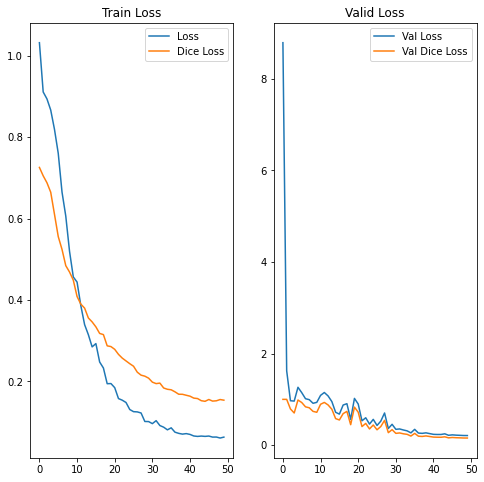

In [78]:
_dice_loss = history_vggunet.history['dice_loss']
_loss = history_vggunet.history['loss']
val_dice_loss = history_vggunet.history['val_dice_loss']
val_loss = history_vggunet.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, _loss, label='Loss')
plt.plot(epochs_range, _dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [79]:
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = vgg_unet(test_images, training=False)
        
        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i, :, :, :])
            plt.title('Input image')
            
            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title('Actual Mask')
            
            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title('Predicted Mask')
            plt.show()

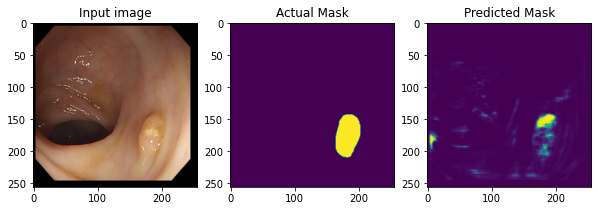

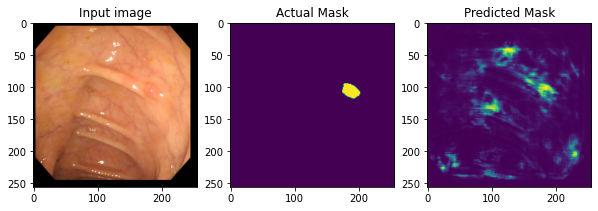

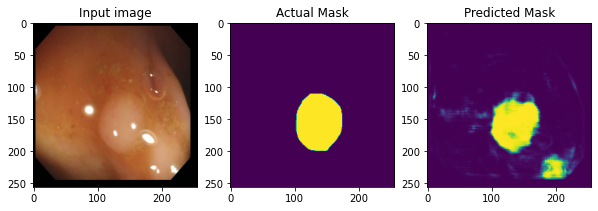

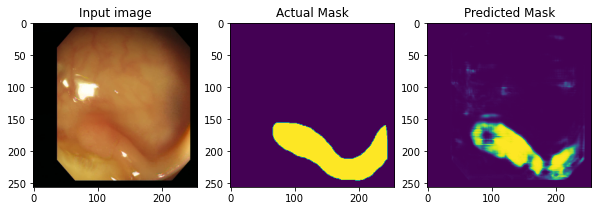

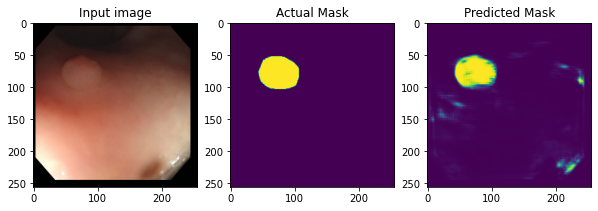

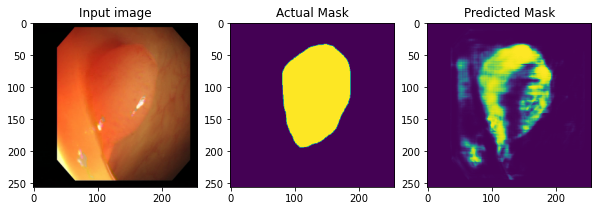

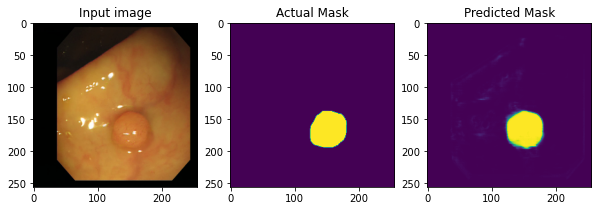

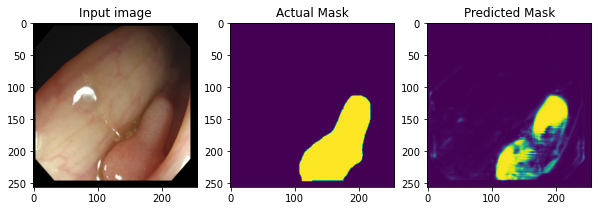

In [80]:
print_images()

In [81]:
mean = []

for images, labels in test_dataset:
    predictions = vgg_unet(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.8339907159665518


### Report
- VGG16을 적용하자 오히려 성능이 떨어졌는데 왜 그런지 몰라 문제를 고치지 못했다